In [1]:
import tensorflow as tf
import numpy as np
import util
from timeit import default_timer as timer
from datetime import datetime
import pickle

In [2]:
XTrainTemp = util.readObject(path='pathXTrain')
YTrainTemp = util.readObject(path='pathYTrain')

XTestTemp = util.readObject(path='pathXTest')
YTestTemp = util.readObject(path='pathYTest')

XValidationTemp = util.readObject(path='pathXValidation')
YValidationTemp = util.readObject(path='pathYValidation')

xpixels_segments_train = util.readObject(path='pathSuperPixelesProcessedTrain')
xpixels_segments_test = util.readObject(path='pathSuperPixelesProcessedTest')
xpixels_segments_validation = util.readObject(path='pathSuperPixelesProcessedValidation')


numEpochs = 100
numFilters = 8
seratio = 4

In [3]:
print(np.shape(XTrainTemp))


(23,)


In [4]:
import importlib
importlib.reload(util)

xTrain, yTrain,xTrainSuperpixeles = util.consolidateInputsAndOutputs(XTrainTemp, YTrainTemp, xpixels_segments_train)
xTest, yTest, xTestSuperpixeles = util.consolidateInputsAndOutputs(XTestTemp, YTestTemp, xpixels_segments_test)
xValidation, yValidation, yValidationSuperpixeles = util.consolidateInputsAndOutputs(XValidationTemp, YValidationTemp, xpixels_segments_validation)

yTrainCopy = yTrain
yTrain = util.integerEncoded(yTrain)
yTest = util.integerEncoded(yTest)
yValidation = util.integerEncoded(yValidation)

In [5]:
from collections import Counter
Counter(yTrainCopy)

Counter({'comment': 65,
         'decoration': 874,
         'page': 23398,
         'periphery': 759,
         'text': 23069})

In [6]:
from collections import Counter
Counter(yTrain)


Counter({0: 65, 1: 874, 2: 23398, 3: 759, 4: 23069})

In [7]:
print(np.shape(xTrain))
print(np.shape(yTrain))

print(np.shape(xTest))
print(np.shape(yTest))

print(np.shape(xValidation))
print(np.shape(yValidation))

(48165, 28, 28)
(48165,)
(16634, 28, 28)
(16634,)
(16813, 28, 28)
(16813,)


In [8]:
xTrain = xTrain.reshape((-1,28,28,1))
xTest = xTest.reshape((-1,28,28,1))
xValidation = xValidation.reshape((-1,28,28,1))
xTrain.shape, yTrain.shape

((48165, 28, 28, 1), (48165,))

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPool2D, Dropout, Input, BatchNormalization, GlobalAvgPool2D, Reshape,Multiply

def conv_layer(inp, f, k=3, s=1, bn=True, se=True, se_ratio=16) :
    out = Conv2D(f, k, strides=s, padding='same', kernel_initializer='he_uniform')(inp)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    if se:
        out_se = GlobalAvgPool2D()(out)
        r = f // se_ratio if (f // se_ratio) > 0 else 1
        out_se = Reshape((1, 1, f))(out_se) # Reshape((1, f))(out_se)
        out_se = Dense(r, use_bias=False, kernel_initializer='he_uniform', activation='relu')(out_se)
        out_se = Dense(f, use_bias=False, activation='sigmoid')(out_se)
        out = Multiply()([out, out_se])    
    return out


Using TensorFlow backend.


In [10]:
def model ():
    x   = Input(shape=(28,28,1))
    out = conv_layer(x, numFilters, se=True, se_ratio=seratio)
    out = Flatten()(out)
    out = Dense(100, kernel_initializer='he_uniform')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.5)(out)
    out = Dense(5, activation='softmax')(out)
    return Model(x, out)

In [11]:
with tf.device('/gpu:0'):
    model = model()


In [12]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 8)     80          input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 28, 28, 8)     32          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 28, 28, 8)     0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [13]:
with tf.device('/gpu:0'):
    hist = model.fit(xTrain, yTrain, validation_data=(xValidation, yValidation), epochs=numEpochs, batch_size=3500)
    #hist = model.fit(xTrain, yTrain, validation_split=0.1, epochs=20, batch_size=2048)

Train on 48165 samples, validate on 16813 samples
Epoch 1/100
48165/48165 [==============================] - 23s - loss: 0.6432 - acc: 0.8106 - val_loss: 4.4331 - val_acc: 0.4150
Epoch 2/100
48165/48165 [==============================] - 3s - loss: 0.3134 - acc: 0.9182 - val_loss: 2.2894 - val_acc: 0.4155
Epoch 3/100
48165/48165 [==============================] - 3s - loss: 0.2441 - acc: 0.9315 - val_loss: 0.7720 - val_acc: 0.5468
Epoch 4/100
48165/48165 [==============================] - 3s - loss: 0.2026 - acc: 0.9423 - val_loss: 0.4178 - val_acc: 0.9335
Epoch 5/100
48165/48165 [==============================] - 3s - loss: 0.1783 - acc: 0.9465 - val_loss: 0.3427 - val_acc: 0.9447
Epoch 6/100
48165/48165 [==============================] - 3s - loss: 0.1599 - acc: 0.9513 - val_loss: 0.3138 - val_acc: 0.9155
Epoch 7/100
48165/48165 [==============================] - 3s - loss: 0.1479 - acc: 0.9543 - val_loss: 0.2962 - val_acc: 0.9265
Epoch 8/100
48165/48165 [============================

48165/48165 [==============================] - 3s - loss: 0.0117 - acc: 0.9975 - val_loss: 0.1586 - val_acc: 0.9686
Epoch 65/100
48165/48165 [==============================] - 3s - loss: 0.0121 - acc: 0.9973 - val_loss: 0.1676 - val_acc: 0.9676
Epoch 66/100
48165/48165 [==============================] - 3s - loss: 0.0113 - acc: 0.9971 - val_loss: 0.1876 - val_acc: 0.9638
Epoch 67/100
48165/48165 [==============================] - 3s - loss: 0.0108 - acc: 0.9976 - val_loss: 0.1771 - val_acc: 0.9654
Epoch 68/100
48165/48165 [==============================] - 3s - loss: 0.0107 - acc: 0.9977 - val_loss: 0.1756 - val_acc: 0.9675
Epoch 69/100
48165/48165 [==============================] - 3s - loss: 0.0110 - acc: 0.9973 - val_loss: 0.1646 - val_acc: 0.9689
Epoch 70/100
48165/48165 [==============================] - 3s - loss: 0.0103 - acc: 0.9974 - val_loss: 0.1828 - val_acc: 0.9653
Epoch 71/100
48165/48165 [==============================] - 3s - loss: 0.0102 - acc: 0.9977 - val_loss: 0.1778

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.DataFrame(hist.history)
df.tail()

,acc,loss,val_acc,val_loss
95,0.998401,0.006568,0.967882,0.205637
96,0.998526,0.006537,0.967644,0.207920
97,0.998651,0.006540,0.968298,0.208874
98,0.998734,0.006303,0.969964,0.189288
99,0.998817,0.005954,0.968477,0.206245


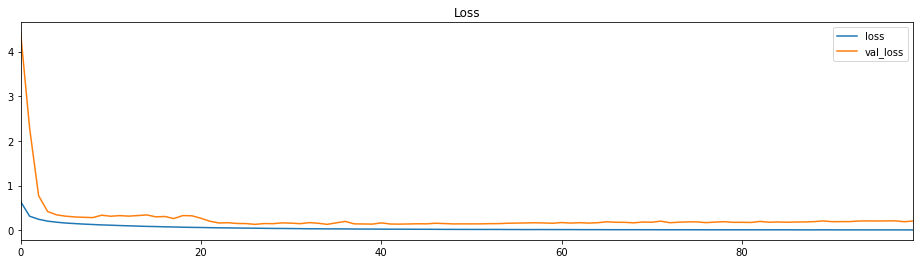

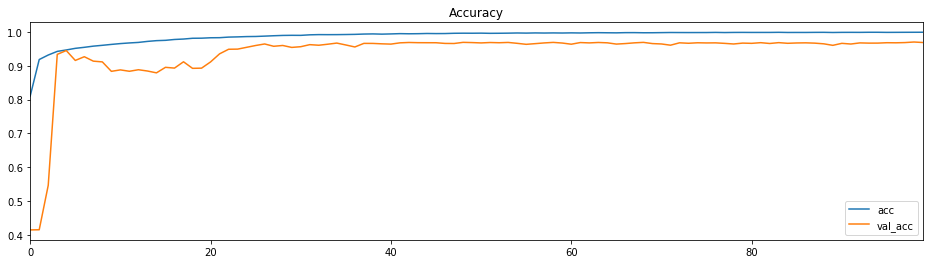

In [15]:
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy');

In [16]:
###saving model
##Saving weights and model
# serialize model to JSON
model_json = model.to_json()
with open("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model1cl.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model1cl.h5py")
print("Saved model to disk")

Saved model to disk


In [17]:
folderPageImages = 'parzivalDataset'; 
folderGroundThruth = 'groundTruth'
ximg_test, xgt_test = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'test', 2**-3)

In [18]:
ximg_test_superpixels = util.segmentImageInSuperpixels(ximg_test, 3000)

In [19]:
#i = np.random.choice(len(ximg_test))
indexSelected = 5
superpixels = ximg_test_superpixels[indexSelected]
img = ximg_test[indexSelected]
XTestToPred, XCentralPointsTest, listSuperPixelesProcessedTest = util.doInputs([img], [superpixels], 28, 'test')
YTestToPred = util.doLabels([XCentralPointsTest[0]], [xgt_test[indexSelected]], folderGroundThruth, 'test', 2**3)


In [20]:
startTime = datetime.now()
#visGT = np.zeros(img.shape[:3], dtype="uint8")
visGT = util.paintGroundTruthImage(img, xgt_test[indexSelected], folderGroundThruth, 'test', 2**3)


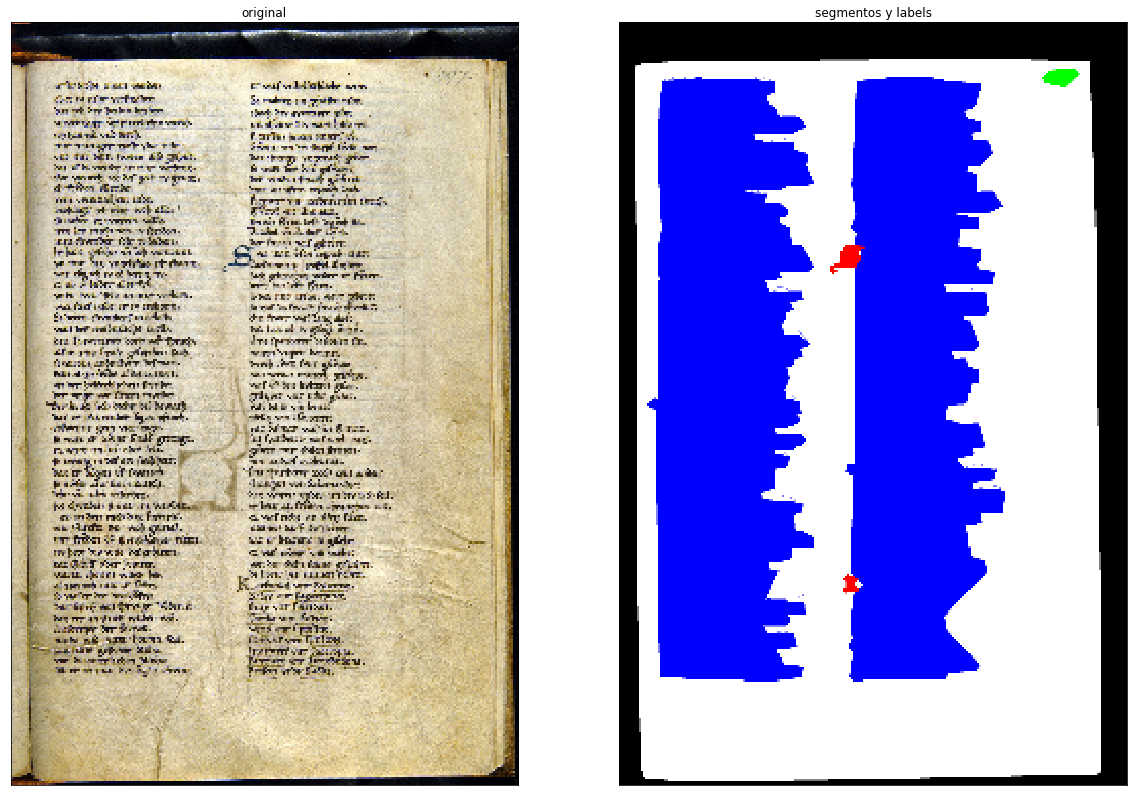

In [21]:
util.subplot(titles=['original','segmentos y labels'], images = [img, visGT], rows = 1, imgPerRows = 2, size = 20)


In [22]:
yPred = []
labels = []
for i in range(len(XTestToPred)) :
    labels = []
    for j in range(len(XTestToPred[i])) :
        predictedLabel = np.argmax(model.predict(XTestToPred[i][j].reshape(1,28,28,1), verbose=0)[0])
        labels.append(predictedLabel)
    yPred.append(labels)

In [23]:
np.shape(yPred)

(1, 2066)

In [24]:
print(yPred[0][0])

3


In [25]:
print(np.shape(img))
print(np.shape(superpixels[0]))
print(np.shape(yPred[0]))
print(len(superpixels))

(376, 250, 3)
(250,)
(2066,)
376


0:comment 1:decoration 2:page 3:periphery 4:text

In [26]:
startTime = datetime.now()
visPred = np.zeros(img.shape[:3], dtype="uint8")

for k in range(len(superpixels)) :
    if yPred[0][k] == 0 :
        visPred[superpixels[k] == 255] = (0, 255, 0)
    elif yPred[0][k] == 1 :
        visPred[superpixels[k] == 255] = (255, 0, 0)
    elif yPred[0][k] == 2 :
        visPred[superpixels[k] == 255] = (255, 255, 255)
    elif yPred[0][k] == 3 :
        visPred[superpixels[k] == 255] = (0, 0, 0)
    elif yPred[0][k] == 4 :
        visPred[superpixels[k] == 255] = (0, 0, 255)    


C:\Users\fascarza\Anaconda3\envs\unet\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 376 but corresponding boolean dimension is 250
  if sys.path[0] == '':
C:\Users\fascarza\Anaconda3\envs\unet\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 376 but corresponding boolean dimension is 250
  # Remove the CWD from sys.path while we load stuff.
C:\Users\fascarza\Anaconda3\envs\unet\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 376 but corresponding boolean dimension is 250
  
C:\Users\fascarza\Anaconda3\envs\unet\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 376 but corresponding boolean dimension is 250


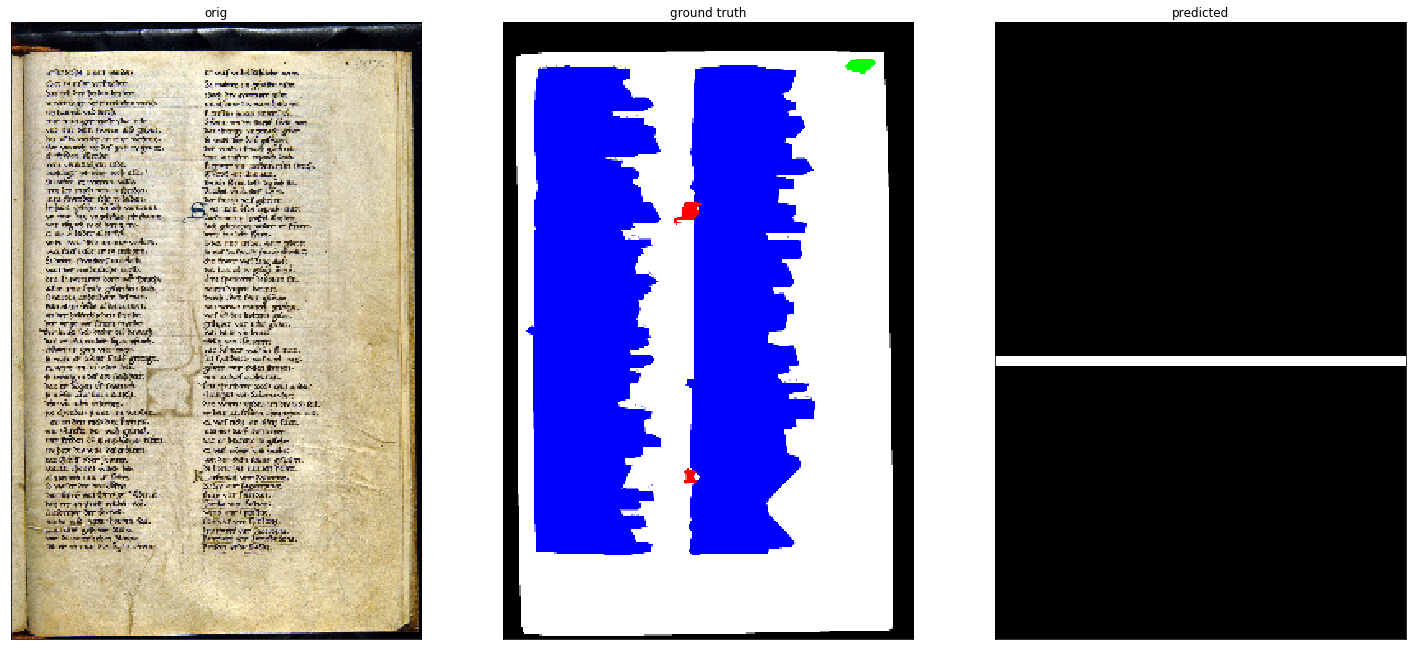

In [27]:
util.subplot(titles=['orig','ground truth', 'predicted'], imgPerRows=3, rows=1, size=25, images=[img, visGT, visPred])

In [28]:
def modelBasic ():
    x   = Input(shape=(28,28,1))
    out = conv_layer(x, numFilters, se=False, se_ratio=seratio)
    out = Flatten()(out)
    out = Dense(100, kernel_initializer='he_uniform')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.5)(out)
    out = Dense(5, activation='softmax')(out)
    return Model(x, out)

In [29]:
with tf.device('/gpu:0'):
    model = modelBasic()
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               627300    
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
__________

In [30]:
with tf.device('/gpu:0'):
    hist = model.fit(xTrain, yTrain, validation_data=(xValidation, yValidation), epochs=numEpochs, batch_size=3500)

Train on 48165 samples, validate on 16813 samples
Epoch 1/100
48165/48165 [==============================] - 3s - loss: 0.9011 - acc: 0.7535 - val_loss: 2.7899 - val_acc: 0.4501
Epoch 2/100
48165/48165 [==============================] - 2s - loss: 0.3747 - acc: 0.9068 - val_loss: 0.5861 - val_acc: 0.8286
Epoch 3/100
48165/48165 [==============================] - 2s - loss: 0.2808 - acc: 0.9257 - val_loss: 0.7968 - val_acc: 0.7548
Epoch 4/100
48165/48165 [==============================] - 2s - loss: 0.2339 - acc: 0.9357 - val_loss: 1.2589 - val_acc: 0.6451
Epoch 5/100
48165/48165 [==============================] - 3s - loss: 0.2036 - acc: 0.9431 - val_loss: 1.4310 - val_acc: 0.6063
Epoch 6/100
48165/48165 [==============================] - 2s - loss: 0.1822 - acc: 0.9469 - val_loss: 1.4156 - val_acc: 0.6060
Epoch 7/100
48165/48165 [==============================] - 2s - loss: 0.1660 - acc: 0.9513 - val_loss: 1.5923 - val_acc: 0.5993
Epoch 8/100
48165/48165 [=============================

48165/48165 [==============================] - 3s - loss: 0.0171 - acc: 0.9955 - val_loss: 0.1609 - val_acc: 0.9656
Epoch 65/100
48165/48165 [==============================] - 3s - loss: 0.0163 - acc: 0.9959 - val_loss: 0.1529 - val_acc: 0.9648
Epoch 66/100
48165/48165 [==============================] - 3s - loss: 0.0155 - acc: 0.9962 - val_loss: 0.1824 - val_acc: 0.9581
Epoch 67/100
48165/48165 [==============================] - 3s - loss: 0.0156 - acc: 0.9961 - val_loss: 0.1571 - val_acc: 0.9621
Epoch 68/100
48165/48165 [==============================] - 3s - loss: 0.0151 - acc: 0.9960 - val_loss: 0.1546 - val_acc: 0.9657
Epoch 69/100
48165/48165 [==============================] - 3s - loss: 0.0145 - acc: 0.9965 - val_loss: 0.1604 - val_acc: 0.9638
Epoch 70/100
48165/48165 [==============================] - 3s - loss: 0.0137 - acc: 0.9969 - val_loss: 0.1582 - val_acc: 0.9641
Epoch 71/100
48165/48165 [==============================] - 3s - loss: 0.0138 - acc: 0.9967 - val_loss: 0.1590

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(hist.history)
df.tail()

,acc,loss,val_acc,val_loss
95,0.997779,0.009353,0.967466,0.167190
96,0.998090,0.008956,0.964195,0.209743
97,0.997820,0.009418,0.966930,0.169917
98,0.997903,0.008917,0.967466,0.172822
99,0.998526,0.008106,0.968120,0.164120


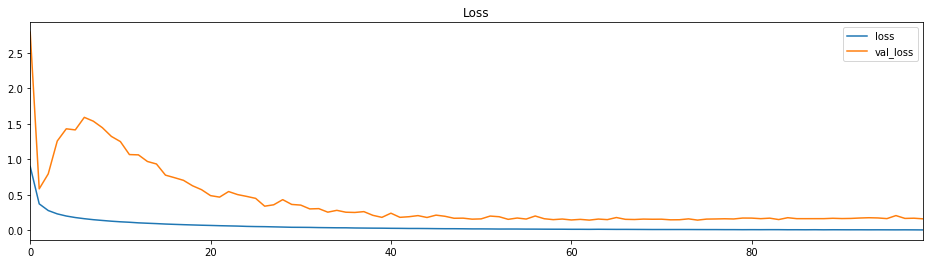

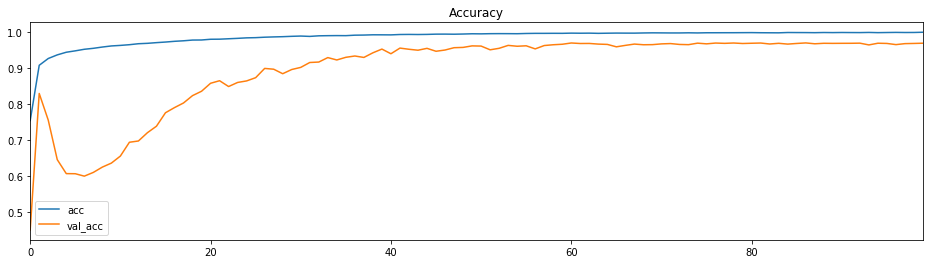

In [32]:
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy');

In [33]:
##Saving weights and model
# serialize model to JSON
model_json = model.to_json()
with open("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model2.h5py")
print("Saved model to disk")

Saved model to disk


In [34]:
print(np.shape(listSuperPixelesProcessedTest))
print(np.shape(yPred))
print(np.shape(ximg_test_superpixels))

(1, 2066, 376, 250)
(1, 2066)
(8, 376, 250)


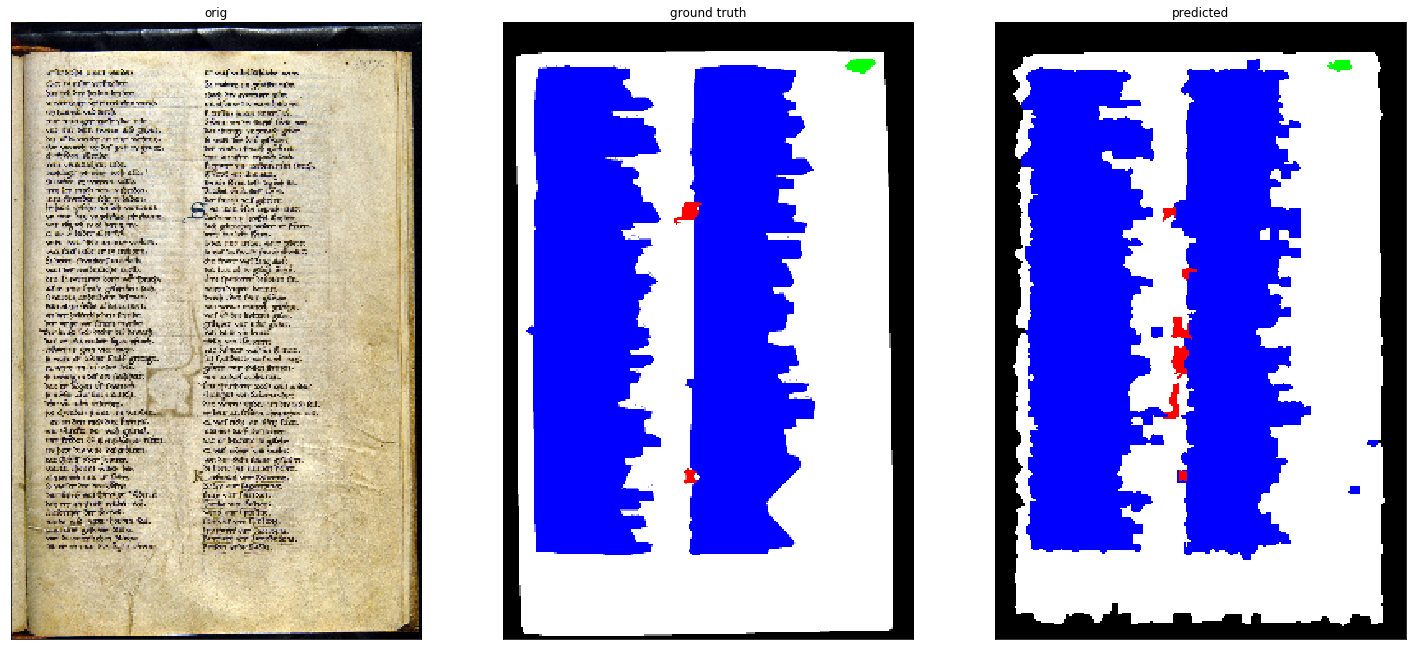

In [35]:
superpixels = ximg_test_superpixels[indexSelected]
img = ximg_test[indexSelected]
XTestToPred, XCentralPointsTest, listSuperPixelesProcessedTest = util.doInputs([img], [superpixels], 28, 'test')
YTestToPred = util.doLabels([XCentralPointsTest[0]], [xgt_test[indexSelected]], folderGroundThruth, 'test', 2**3)

startTime = datetime.now()
#isGT = np.zeros(img.shape[:2], dtype="float")
superpixels = listSuperPixelesProcessedTest[0]

yPred = []
labels = []
for i in range(len(XTestToPred)) :
    labels = []
    for j in range(len(XTestToPred[i])) :
        predictedLabel = np.argmax(model.predict(XTestToPred[i][j].reshape(1,28,28,1), verbose=0)[0])
        labels.append(predictedLabel)
    yPred.append(labels)    
    
startTime = datetime.now()
visPred = np.zeros(img.shape[:3], dtype="uint8")

for k in range(len(superpixels)) :
    if yPred[0][k] == 0 :    
        visPred[superpixels[k] == 255] = (0, 255, 0)
    elif yPred[0][k] == 1 :
        visPred[superpixels[k] == 255] = (255, 0, 0)
    elif yPred[0][k] == 2 :
        visPred[superpixels[k] == 255] = (255, 255, 255)
    elif yPred[0][k] == 3 :
        visPred[superpixels[k] == 255] = (0, 0, 0)
    elif yPred[0][k] == 4 :
        visPred[superpixels[k] == 255] = (0, 0, 255)    
        
util.subplot(titles=['orig','ground truth', 'predicted'], imgPerRows=3, rows=1, size=25, images=[img, visGT, visPred])        